## 001_simple_v1

This run uses a very simple model to get a rough idea for how difficult the problem is.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render 
import models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

/home/che/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../6ceac90d'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [3]:
# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

In [5]:
## READ PATCH DATA

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [5]:
# OPTIONAL: shuffle the data randomly
x_train2, y_train2 = data_prep.shuffle_two_arrays(x_train, y_train)
x_test2, y_test2 = data_prep.shuffle_two_arrays(x_test, y_test)
x_val2, y_val2 = data_prep.shuffle_two_arrays(x_val, y_val)

In [6]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train2 - 1)
y_test_oh  = to_categorical(y_test2 - 1)
y_val_oh   = to_categorical(y_val2 - 1)

In [7]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train2)

x_train2 = (x_train2 - m) / std
x_test2  = (x_test2 - m) / std
x_val2   = (x_val2 - m) / std

In [8]:
## MODEL : load from file, show summary, and compile
reload(models)

model = models.run_002_added_dropout()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
__________

None

In [9]:
reload(data_prep)

data_prep.check_for_nans(x_train2)
data_prep.check_for_nans(x_test2)
data_prep.check_for_nans(x_val2)

print(y_train2[:20], y_test2[:20], y_val2[:20])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2] [1 2 1 1 1 2 2 2 1 2 2 1 1 1 1 2 1 2 1 1] [2 2 1 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 2]


In [10]:
## RUN!!!

# parameters
batch_size = 16
epochs = 5

history = model.fit(x_train2,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test2,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[models.annealer()])

Train on 891 samples, validate on 298 samples
Epoch 1/5
891/891 [==============================] - 32s 36ms/step - loss: 0.3881 - acc: 0.8457 - val_loss: 0.6837 - val_acc: 0.8070
Epoch 2/5
891/891 [==============================] - 32s 36ms/step - loss: 0.2848 - acc: 0.8861 - val_loss: 0.5613 - val_acc: 0.8121
Epoch 3/5
891/891 [==============================] - 32s 36ms/step - loss: 0.2544 - acc: 0.9035 - val_loss: 0.7291 - val_acc: 0.8624
Epoch 4/5
891/891 [==============================] - 46s 52ms/step - loss: 0.2347 - acc: 0.9085 - val_loss: 0.6159 - val_acc: 0.8205
Epoch 5/5
891/891 [==============================] - 37s 41ms/step - loss: 0.2443 - acc: 0.9029 - val_loss: 0.6826 - val_acc: 0.8138


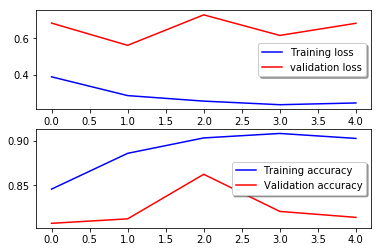

Precision (specificity): 81.667%
Recall (sensitivity): 66.779%
Accuracy: 69.062%
F1: 63.901%


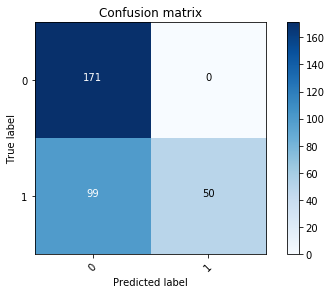

In [11]:
render.plot_training_and_validation_curves(history)

y_pred_oh = model.predict(x_val2)

cm = render.setup_confusion_matrix(y_pred_oh, x_val2, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [12]:
## Second RUN!!! : increase the epochs to 15

history2 = model.fit(x_train2,y_train_oh, batch_size=16,
                              epochs = 10,
                              validation_data = (x_test2,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[models.annealer()])

Train on 891 samples, validate on 298 samples
Epoch 1/10
891/891 [==============================] - 53s 59ms/step - loss: 0.2113 - acc: 0.9153 - val_loss: 1.0474 - val_acc: 0.8691
Epoch 2/10
891/891 [==============================] - 52s 58ms/step - loss: 0.1912 - acc: 0.9259 - val_loss: 1.1411 - val_acc: 0.8372
Epoch 3/10
891/891 [==============================] - 52s 58ms/step - loss: 0.1871 - acc: 0.9287 - val_loss: 0.9044 - val_acc: 0.8574
Epoch 4/10
891/891 [==============================] - 56s 63ms/step - loss: 0.1795 - acc: 0.9276 - val_loss: 1.4158 - val_acc: 0.7919
Epoch 5/10
891/891 [==============================] - 52s 59ms/step - loss: 0.1646 - acc: 0.9355 - val_loss: 1.1184 - val_acc: 0.8591

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
891/891 [==============================] - 51s 57ms/step - loss: 0.1395 - acc: 0.9439 - val_loss: 1.4456 - val_acc: 0.8138
Epoch 7/10
891/891 [==============================] - 61s 68ms/step -

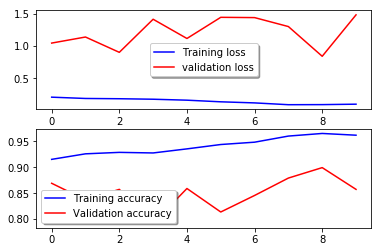

Precision (specificity): 72.451%
Recall (sensitivity): 66.041%
Accuracy: 67.812%
F1: 64.556%


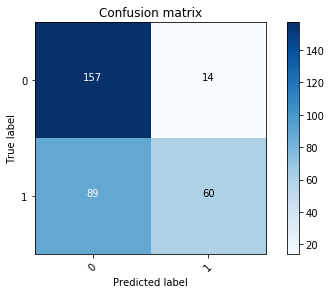

In [13]:
render.plot_training_and_validation_curves(history2)

y_pred_oh = model.predict(x_val2)

cm = render.setup_confusion_matrix(y_pred_oh, x_val2, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)